In [ ]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import time
import re
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.nn.utils import clip_grad_norm_
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [ ]:
with open('/content/drive/MyDrive/rcv1_X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open('/content/drive/MyDrive/rcv1_y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(514824, 200) (514824, 103)
(128707, 200) (128707, 103)
(160883, 200) (160883, 103)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [ ]:
batch_size = 128

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, slope):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(out_features * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(slope)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h, adj):
        Wh = self.W(h)
        num_nodes = Wh.size(0)
        Whi = Wh.repeat_interleave(num_nodes, dim=0)
        Whj = Wh.repeat(num_nodes, 1)
        WhiWhj = torch.cat([Whi, Whj], dim=1)
        Whcat = WhiWhj.view(num_nodes, num_nodes, Wh.size(1) * 2)
        e = self.leakyrelu(self.a(Whcat).squeeze(2))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = self.softmax(attention)
        h_hat = torch.mm(attention, Wh)
        return h_hat


class MAGNET(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        adjacency_matrix,
        num_heads=4,
        slope=0.01,
        dropout=0.5,
    ):

        super(MAGNET, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

        self.attentions1 = nn.ModuleList(
            [
                GraphAttentionLayer(input_size, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh1 = nn.Tanh()

        self.attentions2 = nn.ModuleList(
            [
                GraphAttentionLayer(hidden_size * 2, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh2 = nn.Tanh()

        self.adjacency_matrix = nn.Parameter(adjacency_matrix)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, label_embedding):

        tokens = tokens.unsqueeze(1)

        lstm_output, (hidden, _) = self.rnn(tokens)

        hidden_state = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)

        hidden_state = self.dropout(hidden_state)

        heads_out1 = [
            att(label_embedding, self.adjacency_matrix) for att in self.attentions1
        ]

        head_out1_mean = self.tanh1(torch.stack(heads_out1, dim=0).mean(0))

        heads_out2 = [
            att(head_out1_mean, self.adjacency_matrix) for att in self.attentions2
        ]

        head_out2_mean = self.tanh2(torch.stack(heads_out2, dim=0).mean(0))

        attention = self.dropout(head_out2_mean)

        attention = attention.transpose(0, 1)

        output = torch.mm(hidden_state, attention)

        return output

In [ ]:
def train_model(model, label_embedding, loss_function, optimizer, epochs, device, model_path):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device).float(), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in, label_embedding)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()
            
            y_true_train.extend(output_label.cpu().detach().numpy().tolist())
            y_pred_train.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
        
        model.eval()    

        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device).float(), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model,"/content/drive/MyDrive/MLTC_RCV1/" + model_path)
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [ ]:
def buildAdjacencyCOOC(data_label):
  adj = data_label.T.dot(data_label).astype('float')
  
  for i in range(len(adj)):
    adj[i] = adj[i] / adj[i,i]
  
  return torch.from_numpy(adj.astype('float32'))

In [ ]:
adjacency = buildAdjacencyCOOC(y_train)

<ipython-input-44-7a3abe70c02c>:5: RuntimeWarning: divide by zero encountered in true_divide
  adj[i] = adj[i] / adj[i,i]
<ipython-input-44-7a3abe70c02c>:5: RuntimeWarning: invalid value encountered in true_divide
  adj[i] = adj[i] / adj[i,i]


In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/glove.6B.200d.txt.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/')

In [ ]:
def load_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_file = '/content/drive/MyDrive/glove.6B.200d.txt'
embeddings_index = load_embeddings(embeddings_file)

In [ ]:
with open('/content/drive/MyDrive/rcv1_labels.pickle', 'rb') as f:
    labels = pickle.load(f).values()

In [ ]:
label_embedding = torch.zeros(103, 200)

for index, label in enumerate(labels):
  words = re.split('[ /]', label.lower())
  num_of_words = len(words)
  
  for sublabel in words:
    if sublabel in embeddings_index.keys():
      label_embedding[index] +=  torch.from_numpy(embeddings_index[sublabel])
  label_embedding[index] = label_embedding[index]/num_of_words

label_embedding = label_embedding.float().to(device)
print(label_embedding, label_embedding.shape)

tensor([[-0.2194, -0.1308, -0.1012,  ..., -0.2043,  0.5274,  0.3297],
        [-0.2067,  0.1685,  0.1049,  ..., -0.2648,  0.2501,  0.2149],
        [-0.2471,  0.2324,  0.3084,  ...,  0.0961, -0.2690, -0.0032],
        ...,
        [ 0.2882,  0.8046, -0.2550,  ...,  0.0651,  0.6155,  0.0928],
        [ 0.4567,  0.4979,  0.1550,  ...,  0.2110, -0.0525,  0.3304],
        [ 0.6686,  0.8821,  0.0706,  ...,  0.2025,  0.1855,  0.5253]],
       device='cuda:0') torch.Size([103, 200])


In [ ]:
with open('/content/drive/MyDrive/MLTC_RCV1/label_embedding.pkl', 'wb') as f:
    pickle.dump(label_embedding, f)

In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_4 = MAGNET(200, 250, adjacency.to(device), num_heads=4)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_4.parameters(), lr = learning_rate)
train_loss_4, val_loss_4, avg_epoch_time_4 = train_model(magnet_model_4, label_embedding, loss_function, optimizer, epochs, device, "rcv1_head4.pth")

Epoch :  1


Evaluate: 100%|██████████| 1006/1006 [00:15<00:00, 65.45it/s]


Train F1 Score (Micro) 0.40843729994082106
Val F1 Score (Micro) 0.5945115995214563
Train loss 0.08591950068534117
Val loss 0.05792215867542012
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.34it/s]


Train F1 Score (Micro) 0.6005908019146817
Val F1 Score (Micro) 0.6513249501114703
Train loss 0.06248360764575099
Val loss 0.04945943650472946
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.68it/s]


Train F1 Score (Micro) 0.6470836459623399
Val F1 Score (Micro) 0.7379630171163165
Train loss 0.05727929555540828
Val loss 0.04074227452744724
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.99it/s]


Train F1 Score (Micro) 0.7141155144009819
Val F1 Score (Micro) 0.7565402392855168
Train loss 0.04757531692965867
Val loss 0.03697212216505414
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.35it/s]


Train F1 Score (Micro) 0.7174160405989493
Val F1 Score (Micro) 0.7561837756926524
Train loss 0.047163379211242654
Val loss 0.036994467669020356
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.83it/s]


Train F1 Score (Micro) 0.7318130128357905
Val F1 Score (Micro) 0.7571140927129226
Train loss 0.04502218625670993
Val loss 0.03620650581682238
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.77it/s]


Train F1 Score (Micro) 0.7430423618508681
Val F1 Score (Micro) 0.774494083628838
Train loss 0.04317480305928793
Val loss 0.034236572801355815
Best model saved
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.96it/s]


Train F1 Score (Micro) 0.7481118525631199
Val F1 Score (Micro) 0.7863102002081257
Train loss 0.04229222447570879
Val loss 0.03313277851582818
Best model saved
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 59.57it/s]


Train F1 Score (Micro) 0.7524985097901509
Val F1 Score (Micro) 0.7879560622761846
Train loss 0.041590172674283735
Val loss 0.03264598598959254
Best model saved
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 59.53it/s]


Train F1 Score (Micro) 0.755543949702223
Val F1 Score (Micro) 0.7893492651399295
Train loss 0.04112412195894409
Val loss 0.03226640221346207
Best model saved
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 1006/1006 [00:17<00:00, 58.89it/s]


Train F1 Score (Micro) 0.7579520143767948
Val F1 Score (Micro) 0.7913935133565462
Train loss 0.04072843652367666
Val loss 0.03199834908149529
Best model saved
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.96it/s]


Train F1 Score (Micro) 0.7599599439481872
Val F1 Score (Micro) 0.796352236949825
Train loss 0.04039321848837899
Val loss 0.03155264609621071
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.24it/s]


Train F1 Score (Micro) 0.7609589599889446
Val F1 Score (Micro) 0.7912017860209515
Train loss 0.0402962222024928
Val loss 0.03182868186428876
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.37it/s]


Train F1 Score (Micro) 0.7626095170936475
Val F1 Score (Micro) 0.7999864715869504
Train loss 0.03995468092815158
Val loss 0.031049711396454818
Best model saved
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.49it/s]


Train F1 Score (Micro) 0.7644269617469679
Val F1 Score (Micro) 0.7948608007978115
Train loss 0.0396955262600131
Val loss 0.03132796129415452
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.26it/s]


Train F1 Score (Micro) 0.7648146930894754
Val F1 Score (Micro) 0.7987768231318266
Train loss 0.03966323683964815
Val loss 0.031001346985666936
Best model saved
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.17it/s]


Train F1 Score (Micro) 0.7651108643954443
Val F1 Score (Micro) 0.7978007233455895
Train loss 0.039569737092438335
Val loss 0.03090010688382814
Best model saved
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.76it/s]


Train F1 Score (Micro) 0.7667658738383227
Val F1 Score (Micro) 0.7994329143684369
Train loss 0.039373153697939145
Val loss 0.03077089836150704
Best model saved
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.77it/s]


Train F1 Score (Micro) 0.7668354162583882
Val F1 Score (Micro) 0.8016804810044953
Train loss 0.03937234325283963
Val loss 0.030573683833447888
Best model saved
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.19it/s]


Train F1 Score (Micro) 0.767977316404149
Val F1 Score (Micro) 0.8028342533723848
Train loss 0.03920322521991348
Val loss 0.030439095119862387
Best model saved
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.34it/s]


Train F1 Score (Micro) 0.768640873373956
Val F1 Score (Micro) 0.8038924441981631
Train loss 0.039069280248267745
Val loss 0.030316111181768225
Best model saved
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.36it/s]


Train F1 Score (Micro) 0.7691528810071961
Val F1 Score (Micro) 0.803916179355707
Train loss 0.0389757676046826
Val loss 0.030331141335767496
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.83it/s]


Train F1 Score (Micro) 0.7698488982800645
Val F1 Score (Micro) 0.8044851175521734
Train loss 0.038929175333636865
Val loss 0.030178653950216044
Best model saved
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 60.07it/s]


Train F1 Score (Micro) 0.7695640259159136
Val F1 Score (Micro) 0.805639924944991
Train loss 0.03895961921203723
Val loss 0.030078180663835694
Best model saved
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.38it/s]


Train F1 Score (Micro) 0.7706857370904159
Val F1 Score (Micro) 0.8055959675718357
Train loss 0.038763145009380294
Val loss 0.030035652959012015
Best model saved
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.21it/s]


Train F1 Score (Micro) 0.7709806968957963
Val F1 Score (Micro) 0.8086815619508411
Train loss 0.03867020057488845
Val loss 0.02983155185041975
Best model saved
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 1006/1006 [00:17<00:00, 58.93it/s]


Train F1 Score (Micro) 0.7708192300683868
Val F1 Score (Micro) 0.8038058686701174
Train loss 0.03875858338631684
Val loss 0.030135317914795214
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 59.72it/s]


Train F1 Score (Micro) 0.7723413048570144
Val F1 Score (Micro) 0.8037887640266025
Train loss 0.03853196613147962
Val loss 0.03007445532910037
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.37it/s]


Train F1 Score (Micro) 0.7721515389100506
Val F1 Score (Micro) 0.804049054386385
Train loss 0.038569859582990994
Val loss 0.03001737491659094
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 1006/1006 [00:16<00:00, 61.24it/s]


Train F1 Score (Micro) 0.7723422328372963
Val F1 Score (Micro) 0.806063174082733
Train loss 0.03852545125713225
Val loss 0.029873476298914754
------------------------------------------------


In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_2 = MAGNET(200, 250, adjacency.to(device), num_heads=2)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_2.parameters(), lr = learning_rate)
train_loss_2, val_loss_2, avg_epoch_time_2 = train_model(magnet_model_2, label_embedding, loss_function, optimizer, epochs, device, "rcv1_head2.pth")

Epoch :  1


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.36it/s] 


Train F1 Score (Micro) 0.19090004706907643
Val F1 Score (Micro) 0.08419766494705402
Train loss 0.1044898838927104
Val loss 0.10193263760825275
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 85.55it/s] 


Train F1 Score (Micro) 0.2537130156474012
Val F1 Score (Micro) 0.45135401109985324
Train loss 0.09567498278475625
Val loss 0.0721416587480316
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 87.02it/s]


Train F1 Score (Micro) 0.5504524807778655
Val F1 Score (Micro) 0.6023014581381203
Train loss 0.06921081227351562
Val loss 0.05563873562880349
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 1006/1006 [00:10<00:00, 94.42it/s]


Train F1 Score (Micro) 0.643708903760078
Val F1 Score (Micro) 0.7006742319998922
Train loss 0.057853707694130216
Val loss 0.04489887663520591
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 81.12it/s]


Train F1 Score (Micro) 0.5955097955740473
Val F1 Score (Micro) 0.6714182907349467
Train loss 0.06497542082470743
Val loss 0.04800832400442829
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 80.76it/s] 


Train F1 Score (Micro) 0.6544077304357142
Val F1 Score (Micro) 0.3965896358441912
Train loss 0.05618950119739796
Val loss 0.09115186125543671
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 1006/1006 [00:10<00:00, 99.74it/s]


Train F1 Score (Micro) 0.5683135745576691
Val F1 Score (Micro) 0.6783250460885331
Train loss 0.06647510916316891
Val loss 0.04587328433620171
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 85.12it/s]


Train F1 Score (Micro) 0.6548411081599148
Val F1 Score (Micro) 0.6712515612669099
Train loss 0.05583798603842041
Val loss 0.04465797464279958
Best model saved
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 83.60it/s]


Train F1 Score (Micro) 0.6851957553946461
Val F1 Score (Micro) 0.752284727934921
Train loss 0.05184697100983874
Val loss 0.03872012674334509
Best model saved
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.37it/s]


Train F1 Score (Micro) 0.6893284848450913
Val F1 Score (Micro) 0.7292727798635389
Train loss 0.051291116687631005
Val loss 0.039517167218725675
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.91it/s]


Train F1 Score (Micro) 0.7023843351301803
Val F1 Score (Micro) 0.25702264279798887
Train loss 0.049403898311459894
Val loss 0.08156152445060122
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 85.68it/s]


Train F1 Score (Micro) 0.6916593173548327
Val F1 Score (Micro) 0.7531789001083967
Train loss 0.050604011777352256
Val loss 0.03720384816015158
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 1006/1006 [00:09<00:00, 101.61it/s]


Train F1 Score (Micro) 0.6935270057995467
Val F1 Score (Micro) 0.7340823097290229
Train loss 0.05031855812742139
Val loss 0.039780479429982175
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 82.84it/s]


Train F1 Score (Micro) 0.6897433896098648
Val F1 Score (Micro) 0.7187434269581369
Train loss 0.050916915933994875
Val loss 0.039600201606543116
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 87.21it/s]


Train F1 Score (Micro) 0.7051576526663669
Val F1 Score (Micro) 0.7581086771924254
Train loss 0.04876598979876819
Val loss 0.03744699147753936
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.89it/s]


Train F1 Score (Micro) 0.71245876302652
Val F1 Score (Micro) 0.7703276294787675
Train loss 0.04773301235023954
Val loss 0.03584026146650492
Best model saved
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.94it/s]


Train F1 Score (Micro) 0.7130638151337652
Val F1 Score (Micro) 0.7421897308290746
Train loss 0.047739429128516704
Val loss 0.037316781463134836
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 83.95it/s]


Train F1 Score (Micro) 0.7187207327618211
Val F1 Score (Micro) 0.7700613263182076
Train loss 0.04687710409081607
Val loss 0.035230488379376666
Best model saved
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 87.32it/s]


Train F1 Score (Micro) 0.7217306520247833
Val F1 Score (Micro) 0.7632406996460802
Train loss 0.0464850456585583
Val loss 0.0356644176846559
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.93it/s]


Train F1 Score (Micro) 0.7048938756531447
Val F1 Score (Micro) 0.7701940980287648
Train loss 0.049235950711871035
Val loss 0.03513445854409196
Best model saved
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 86.25it/s]


Train F1 Score (Micro) 0.7248179829005246
Val F1 Score (Micro) 0.7789822095803973
Train loss 0.046108659540180126
Val loss 0.034217605304350675
Best model saved
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 1006/1006 [00:10<00:00, 99.58it/s]


Train F1 Score (Micro) 0.725898242723797
Val F1 Score (Micro) 0.7568093694266135
Train loss 0.04596633326031662
Val loss 0.03573925134949905
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 85.20it/s]


Train F1 Score (Micro) 0.7218909960302893
Val F1 Score (Micro) 0.7505834724878597
Train loss 0.04648004386508284
Val loss 0.03777405349111877
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 1006/1006 [00:09<00:00, 102.34it/s]


Train F1 Score (Micro) 0.7081601802338628
Val F1 Score (Micro) 0.7679780099702478
Train loss 0.048132667450867216
Val loss 0.035221975759619745
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 82.46it/s]


Train F1 Score (Micro) 0.7220550403624776
Val F1 Score (Micro) 0.786023200857513
Train loss 0.046393882858273165
Val loss 0.03350792427882404
Best model saved
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 1006/1006 [00:11<00:00, 84.36it/s]


Train F1 Score (Micro) 0.729284180498525
Val F1 Score (Micro) 0.7703576447213689
Train loss 0.045483148156515024
Val loss 0.03469116792682684
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 82.75it/s]


Train F1 Score (Micro) 0.7341342421589877
Val F1 Score (Micro) 0.7785563834974307
Train loss 0.04475895538620545
Val loss 0.03362723611569251
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 82.95it/s]


Train F1 Score (Micro) 0.7358084585160426
Val F1 Score (Micro) 0.7847926049090793
Train loss 0.04445766795471981
Val loss 0.033087064076963046
Best model saved
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 82.56it/s]


Train F1 Score (Micro) 0.7384392809578216
Val F1 Score (Micro) 0.7888888888888889
Train loss 0.04403806493388178
Val loss 0.032616127869317946
Best model saved
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 1006/1006 [00:12<00:00, 83.76it/s] 


Train F1 Score (Micro) 0.7388341663868804
Val F1 Score (Micro) 0.7934195696229608
Train loss 0.04396584071450467
Val loss 0.03247134307506781
Best model saved
------------------------------------------------


In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_8 = MAGNET(200, 250, adjacency.to(device), num_heads=8)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_8.parameters(), lr = learning_rate)
train_loss_8, val_loss_8, avg_epoch_time_8 = train_model(magnet_model_8, label_embedding, loss_function, optimizer, epochs, device, "rcv1_head8.pth")

Epoch :  1


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.34it/s]


Train F1 Score (Micro) 0.44462559614200525
Val F1 Score (Micro) 0.6154930549098534
Train loss 0.08109416040468506
Val loss 0.05433122795926885
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.28it/s]


Train F1 Score (Micro) 0.6330605130893617
Val F1 Score (Micro) 0.7108403801275965
Train loss 0.05722859088843538
Val loss 0.04228966843122042
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 1006/1006 [00:23<00:00, 42.17it/s]


Train F1 Score (Micro) 0.6996851792225242
Val F1 Score (Micro) 0.7467181401949686
Train loss 0.04959624591152703
Val loss 0.038987573786133205
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.68it/s]


Train F1 Score (Micro) 0.7282984030607264
Val F1 Score (Micro) 0.7704613364345054
Train loss 0.04533741987867569
Val loss 0.03511123477886792
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.16it/s]


Train F1 Score (Micro) 0.7402957489253849
Val F1 Score (Micro) 0.7634629113571649
Train loss 0.04332278649758602
Val loss 0.03536539005808103
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.39it/s]


Train F1 Score (Micro) 0.6941912048413318
Val F1 Score (Micro) 0.7770750221631205
Train loss 0.04823422100623686
Val loss 0.034311198536862084
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.51it/s]


Train F1 Score (Micro) 0.7333180254133983
Val F1 Score (Micro) 0.7601905975565837
Train loss 0.04439304198022435
Val loss 0.035810462560201026
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.31it/s]


Train F1 Score (Micro) 0.7334071227895105
Val F1 Score (Micro) 0.76125462288468
Train loss 0.04387536352968412
Val loss 0.03476395449095644
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.27it/s]


Train F1 Score (Micro) 0.7281668804737269
Val F1 Score (Micro) 0.7300984182826784
Train loss 0.044296916297366304
Val loss 0.03774745134122033
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.72it/s]


Train F1 Score (Micro) 0.7103963955327612
Val F1 Score (Micro) 0.670190059413097
Train loss 0.04598147705430686
Val loss 0.04252868430470496
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.64it/s]


Train F1 Score (Micro) 0.635132937996736
Val F1 Score (Micro) 0.6584024386432916
Train loss 0.05272500439941246
Val loss 0.041913525888300086
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 1006/1006 [00:23<00:00, 42.51it/s]


Train F1 Score (Micro) 0.6468783200075391
Val F1 Score (Micro) 0.7756543381248543
Train loss 0.051254430341759104
Val loss 0.03422719656784184
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.76it/s]


Train F1 Score (Micro) 0.7441050903557466
Val F1 Score (Micro) 0.7927577716346054
Train loss 0.042130613576860654
Val loss 0.03191247444866488
Best model saved
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.32it/s]


Train F1 Score (Micro) 0.7495187177174497
Val F1 Score (Micro) 0.7820948722372172
Train loss 0.041558914155549534
Val loss 0.03248290233239976
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 38.94it/s]


Train F1 Score (Micro) 0.7486392633132232
Val F1 Score (Micro) 0.7797594099556378
Train loss 0.04134783691678241
Val loss 0.03278793707660309
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.65it/s]


Train F1 Score (Micro) 0.6556829327583834
Val F1 Score (Micro) 0.6536182029767341
Train loss 0.05073737324102731
Val loss 0.04234929128770326
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 1006/1006 [00:23<00:00, 42.37it/s]


Train F1 Score (Micro) 0.628831616820405
Val F1 Score (Micro) 0.6664279392742869
Train loss 0.05317241102901526
Val loss 0.04221449460219555
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.47it/s]


Train F1 Score (Micro) 0.6405723292167732
Val F1 Score (Micro) 0.6778894397506091
Train loss 0.05161995057821304
Val loss 0.04105025909981777
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 1006/1006 [00:23<00:00, 42.73it/s]


Train F1 Score (Micro) 0.6344149723431848
Val F1 Score (Micro) 0.6811004038878535
Train loss 0.0523588364421136
Val loss 0.04098965327772006
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.23it/s]


Train F1 Score (Micro) 0.6734002119098154
Val F1 Score (Micro) 0.7784257434110619
Train loss 0.04857264482051601
Val loss 0.03332296727969502
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.56it/s]


Train F1 Score (Micro) 0.7431782164718044
Val F1 Score (Micro) 0.7839455517006968
Train loss 0.0422378296521938
Val loss 0.03243611005892159
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.35it/s]


Train F1 Score (Micro) 0.7480186970036666
Val F1 Score (Micro) 0.7854805238433238
Train loss 0.04159332182663029
Val loss 0.032048688297924656
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.64it/s]


Train F1 Score (Micro) 0.7500586209957223
Val F1 Score (Micro) 0.7827500954536961
Train loss 0.041334104698994935
Val loss 0.032772116620412045
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.34it/s]


Train F1 Score (Micro) 0.7450350550723059
Val F1 Score (Micro) 0.7845947689174771
Train loss 0.042138745298499404
Val loss 0.032244385460810085
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.46it/s]


Train F1 Score (Micro) 0.7496088466592755
Val F1 Score (Micro) 0.7839407011163391
Train loss 0.041349773078308664
Val loss 0.03216752614900025
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.04it/s]


Train F1 Score (Micro) 0.7510329798438111
Val F1 Score (Micro) 0.7828915728494918
Train loss 0.0411769156553742
Val loss 0.032136140904106034
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.81it/s]


Train F1 Score (Micro) 0.7362056809058704
Val F1 Score (Micro) 0.7836238892041366
Train loss 0.04363810378810881
Val loss 0.032393990728863425
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.33it/s]


Train F1 Score (Micro) 0.7435088483463174
Val F1 Score (Micro) 0.7790352768626249
Train loss 0.04234621816426108
Val loss 0.03281694092597094
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 1006/1006 [00:23<00:00, 42.88it/s]


Train F1 Score (Micro) 0.7420202988891553
Val F1 Score (Micro) 0.7871967355951098
Train loss 0.042456661046603235
Val loss 0.03179983783579963
Best model saved
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 1006/1006 [00:25<00:00, 39.59it/s]


Train F1 Score (Micro) 0.7496573876442031
Val F1 Score (Micro) 0.7884625763692494
Train loss 0.04132763312200305
Val loss 0.03164360289152704
Best model saved
------------------------------------------------


# Evaluation

In [ ]:
def test_scores(model, device, label_embedding):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.float().to(device), output_label.to(device)

            pred_batch = model(sequence_in, label_embedding)

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_pred = y_pred >= 0.5

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0))

In [ ]:
best_model_4 = torch.load('/content/drive/MyDrive/MLTC_RCV1rcv1_head4.pth')
test_scores(best_model_4, device, label_embedding)

Evaluate: 100%|██████████| 1257/1257 [00:24<00:00, 50.31it/s]


Test Accuracy 0.5042732917710386
Test F1 Score (Micro) 0.8076744031389239
Classification report
              precision    recall  f1-score   support

           0       0.82      0.13      0.23      4880
           1       0.88      0.44      0.59      2353
           2       0.76      0.21      0.33      7468
           3       0.63      0.11      0.19      1412
           4       0.95      0.89      0.92     30358
           5       0.96      0.85      0.90     16478
           6       0.93      0.69      0.79      4642
           7       0.90      0.73      0.81     14554
           8       0.00      0.00      0.00       416
           9       0.90      0.64      0.75      8427
          10       0.91      0.47      0.62      3615
          11       0.91      0.54      0.68      2353
          12       1.00      0.01      0.02       493
          13       0.99      0.44      0.61      1184
          14       0.88      0.73      0.80     10633
          15       0.84      0.68      

In [ ]:
best_model_2 = torch.load('/content/drive/MyDrive/MLTC_RCV1rcv1_head2.pth')
test_scores(best_model_2, device, label_embedding)

Evaluate: 100%|██████████| 1257/1257 [00:13<00:00, 91.93it/s] 


Test Accuracy 0.4863410055754803
Test F1 Score (Micro) 0.792486189297815
Classification report
              precision    recall  f1-score   support

           0       0.78      0.06      0.11      4880
           1       0.90      0.35      0.50      2353
           2       0.74      0.14      0.23      7468
           3       0.56      0.01      0.01      1412
           4       0.95      0.88      0.91     30358
           5       0.96      0.84      0.90     16478
           6       0.91      0.68      0.78      4642
           7       0.88      0.73      0.80     14554
           8       0.00      0.00      0.00       416
           9       0.92      0.55      0.69      8427
          10       0.92      0.43      0.58      3615
          11       0.95      0.30      0.46      2353
          12       0.00      0.00      0.00       493
          13       0.99      0.16      0.28      1184
          14       0.90      0.66      0.76     10633
          15       0.82      0.69      0

In [ ]:
best_model_8 = torch.load('/content/drive/MyDrive/MLTC_RCV1rcv1_head8.pth')
test_scores(best_model_8, device, label_embedding)

Evaluate: 100%|██████████| 1257/1257 [00:29<00:00, 41.97it/s]


Test Accuracy 0.42227581534406994
Test F1 Score (Micro) 0.7869712461442223
Classification report
              precision    recall  f1-score   support

           0       0.83      0.10      0.18      4880
           1       0.89      0.40      0.55      2353
           2       0.75      0.20      0.32      7468
           3       0.65      0.10      0.18      1412
           4       0.97      0.66      0.79     30358
           5       0.95      0.85      0.90     16478
           6       0.95      0.64      0.76      4642
           7       0.55      0.78      0.64     14554
           8       0.00      0.00      0.00       416
           9       0.90      0.63      0.74      8427
          10       0.88      0.54      0.67      3615
          11       0.91      0.55      0.68      2353
          12       1.00      0.01      0.03       493
          13       0.98      0.57      0.72      1184
          14       0.90      0.69      0.78     10633
          15       0.83      0.69     

In [ ]:
num_params = sum(p.numel() for p in best_model_4.parameters() if p.requires_grad) 

print(best_model_4)
print(f'The model has {num_params:,} trainable parameters')

MAGNET(
  (rnn): LSTM(200, 250, batch_first=True, bidirectional=True)
  (attentions1): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=200, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh1): Tanh()
  (attentions2): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=500, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh2): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,322,609 trainable parameters


In [ ]:
# print('Train loss', train_loss)
# print('Val loss', val_loss)

In [ ]:
# print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

In [ ]:
print('Train loss', train_loss_2)
print('Val loss', val_loss_2)

Train loss [0.1044898838927104, 0.09567498278475625, 0.06921081227351562, 0.057853707694130216, 0.06497542082470743, 0.05618950119739796, 0.06647510916316891, 0.05583798603842041, 0.05184697100983874, 0.051291116687631005, 0.049403898311459894, 0.050604011777352256, 0.05031855812742139, 0.050916915933994875, 0.04876598979876819, 0.04773301235023954, 0.047739429128516704, 0.04687710409081607, 0.0464850456585583, 0.049235950711871035, 0.046108659540180126, 0.04596633326031662, 0.04648004386508284, 0.048132667450867216, 0.046393882858273165, 0.045483148156515024, 0.04475895538620545, 0.04445766795471981, 0.04403806493388178, 0.04396584071450467]
Val loss [0.10193263760825275, 0.0721416587480316, 0.05563873562880349, 0.04489887663520591, 0.04800832400442829, 0.09115186125543671, 0.04587328433620171, 0.04465797464279958, 0.03872012674334509, 0.039517167218725675, 0.08156152445060122, 0.03720384816015158, 0.039780479429982175, 0.039600201606543116, 0.03744699147753936, 0.03584026146650492, 0

In [ ]:
print('Train loss', train_loss_4)
print('Val loss', val_loss_4)

Train loss [0.08591950068534117, 0.06248360764575099, 0.05727929555540828, 0.04757531692965867, 0.047163379211242654, 0.04502218625670993, 0.04317480305928793, 0.04229222447570879, 0.041590172674283735, 0.04112412195894409, 0.04072843652367666, 0.04039321848837899, 0.0402962222024928, 0.03995468092815158, 0.0396955262600131, 0.03966323683964815, 0.039569737092438335, 0.039373153697939145, 0.03937234325283963, 0.03920322521991348, 0.039069280248267745, 0.0389757676046826, 0.038929175333636865, 0.03895961921203723, 0.038763145009380294, 0.03867020057488845, 0.03875858338631684, 0.03853196613147962, 0.038569859582990994, 0.03852545125713225]
Val loss [0.05792215867542012, 0.04945943650472946, 0.04074227452744724, 0.03697212216505414, 0.036994467669020356, 0.03620650581682238, 0.034236572801355815, 0.03313277851582818, 0.03264598598959254, 0.03226640221346207, 0.03199834908149529, 0.03155264609621071, 0.03182868186428876, 0.031049711396454818, 0.03132796129415452, 0.031001346985666936, 0.0

In [ ]:
print('Train loss', train_loss_8)
print('Val loss', val_loss_8)

Train loss [0.08109416040468506, 0.05722859088843538, 0.04959624591152703, 0.04533741987867569, 0.04332278649758602, 0.04823422100623686, 0.04439304198022435, 0.04387536352968412, 0.044296916297366304, 0.04598147705430686, 0.05272500439941246, 0.051254430341759104, 0.042130613576860654, 0.041558914155549534, 0.04134783691678241, 0.05073737324102731, 0.05317241102901526, 0.05161995057821304, 0.0523588364421136, 0.04857264482051601, 0.0422378296521938, 0.04159332182663029, 0.041334104698994935, 0.042138745298499404, 0.041349773078308664, 0.0411769156553742, 0.04363810378810881, 0.04234621816426108, 0.042456661046603235, 0.04132763312200305]
Val loss [0.05433122795926885, 0.04228966843122042, 0.038987573786133205, 0.03511123477886792, 0.03536539005808103, 0.034311198536862084, 0.035810462560201026, 0.03476395449095644, 0.03774745134122033, 0.04252868430470496, 0.041913525888300086, 0.03422719656784184, 0.03191247444866488, 0.03248290233239976, 0.03278793707660309, 0.04234929128770326, 0.0

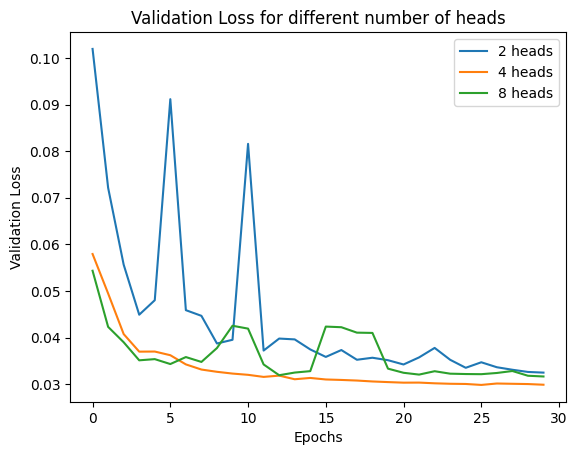

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_loss_2, label='2 heads')
plt.plot(val_loss_4, label='4 heads')
plt.plot(val_loss_8, label='8 heads')

# add title and labels to the plot
plt.title('Validation Loss for different number of heads')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

# add legend to the plot
plt.legend()

# show the plot
plt.show()
